
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## HyCReeW runup estimation 

inputs required: 
  * Nearshore reconstructed historical storms
  * Nearshore reconstructed simulated storms
  * Historical water levels
  * Synthetic water levels 

in this notebook:
  * HyCReWW runup estimation of historical and synthetic events
  * Extreme value analysis and validation


### Workflow:

<div>
<img src="resources/nb02_04.png" width="400px">
</div>



**HyCReWW** provides wave-driven run-up estimations along coral reef-lined shorelines under a wide range of fringing reef morphologies and offshore forcing characteristics. The metamodel is based on two models: (a) a full factorial design of recent XBeach Non-Hydrostatic simulations under different reef configurations and offshore wave and water level conditions (Pearson et al, 2017); and (b) Radial Basis Functions (RBFs) for approximating the non-linear function of run-up for the set of multivariate parameters:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Runup = RBF($\eta_0$, $H_0$, ${H_0/L_0}$, $\beta_f$,$W_reef$, $\beta_b$, $c_f$ );&nbsp;&nbsp;&nbsp;&nbsp;</center>

Where, the hydrodynamic variables defined are offshore water level ($\eta_0$), significant wave height ($H_0$), and wave steepness (${H_0/L_0}$); the reef morphologic parameters include fore reef slope ($\beta_f$), reef flat width ($W_reef$), beach slope ($\beta_b$), and seabed roughness ($c_f$). ${L_0}$ is the deep water wave length $L_0=gT_p^2/2pi$, and $T_p$ is the peak period. Beach crest elevation ($z_b$) was fixed at a height of 30 m to focus on run-up as a proxy for coastal inundation.

<img src="resources/nb02_04_profile.png">


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import pandas as pd
import xarray as xr
from scipy.interpolate import griddata

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.rbf import RBF_Interpolation
from teslakit.mda import Normalize

from teslakit.plotting.extremes import Plot_ReturnPeriodValidation



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/nico/Projects/TESLA-kit/TeslaKit/data'
db = Database(p_data)

# set site
db.SetSite('ROI')


# reef characteristics
reef_cs = {
    'rslope': 0.0505,
    'bslope': 0.1667,
    'rwidth': 250,
    'cf': 0.0105,
}


# load Hycreww RBF coefficients and sim. variables min. and max.
var_lims, rbf_coeffs = db.Load_HYCREWW()


In [3]:
# hycreww interpolation 

def hycreww_runup(var_lims, rbf_coeffs, dset):
    '''
    Calculates RunUp using hycreww RBFs (level) and linear interpolation (Runup)
    
    var_lims   - hycreww variables min and max limits
    rbf_coeffs - hycreww rbf coefficients
    dset       - input dataset (pandas.DataFrame with "rbf_vns" columns)
    
    '''
    
    # RBF wave conditions 
    rbf_hs = [1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5]
    rbf_hs_lo = [0.005, 0.025, 0.05, 0.005, 0.025, 0.05, 0.005, 0.025, 0.05, 0.005, 0.025, 0.05, 0.005, 0.025, 0.05 ]
    rbf_vns = ['level', 'rslope', 'bslope', 'rwidth', 'cf']
    
    # RBF parameters
    ix_sc = [0, 1, 2, 3, 4]
    ix_dr = []
    minis = [var_lims[x][0] for x in rbf_vns]
    maxis = [var_lims[x][1] for x in rbf_vns]
    
    
    # add reef characteristics
    for p in reef_cs.keys():
        dset[p] = reef_cs[p]

    # discard data outside limits
    for vn in var_lims.keys():
        dset = dset[(dset[vn] > var_lims[vn][0]) &(dset[vn] < var_lims[vn][1])]
    
    
    # RBF dataset to interpolate
    ds_in = dset[rbf_vns]

    # normalize data
    ds_nm ,_ ,_ = Normalize(ds_in.values, ix_sc, ix_dr, minis=minis, maxis=maxis)

    # RBF interpolation (with all cases?)
    ru_out = []
    for rc in rbf_coeffs:
        ro = RBF_Interpolation(rc['constant'], rc['coeff'], rc['nodes'], ds_nm.T)
        ru_out.append(ro)
    ru_z = np.array(ru_out)
    
    # RU Linear interpolation (hs, hs_lo -> runup)
    RU = []
    for c, (_, r) in enumerate(dset.iterrows()):
        vq = griddata((rbf_hs, rbf_hs_lo), ru_z[:,c], (r['hs'], r['hs_lo2']), method='linear')
        RU.append(vq)
    RU = np.array(RU)
    
    # store runup alongside input data
    dset_out = dset.copy()
    dset_out['runup'] = dset_out['level'] + RU

    return dset_out



## Hycreww RBF Interpolation: Historical

In [4]:
# Load complete historical data and nearshore waves
data = db.Load_HIST_Complete_daily() 
waves = db.Load_NEARSHORE_RECONSTRUCTION_HIST_storms()

waves = waves.rename_vars({"Hs": "hs", "Tp": "tp", 'Dir':'dir'})  # rename vars
waves['hs_lo2'] = waves['hs']/(1.5613*waves['tp']**2)             # calc. hs_lo2
waves['level'] = data.sel(time=waves.time).level                  # add level


# calculate runup with hycreww
dset = waves[['hs', 'tp', 'dir', 'level', 'hs_lo2']].to_dataframe()
out_hist = hycreww_runup(var_lims, rbf_coeffs, dset)

# store historical runup
db.Save_NEARSHORE_RUNUP_HIST(out_hist)



## Hycreww RBF Interpolation: Simulation

In [5]:
# Load complete simulations data and nearshore waves

n_sims_DWT = 10
data_list = db.Load_SIM_Complete_storms(n_sims=n_sims_DWT)
waves_list = db.Load_NEARSHORE_RECONSTRUCTION_SIM_storms(n_sims=n_sims_DWT)

# iterate storms waves simulations
l_sims = []
for dd, ww in zip(data_list, waves_list):
    
    ww = ww.rename_vars({"Hs": "hs", "Tp": "tp", 'Dir':'dir'})  # rename vars
    ww['hs_lo2'] = ww['hs']/(1.5613*ww['tp']**2)                # calc. hs_lo2
    ww['level'] = dd.sel(time=ww.time).level                    # add level
    
    # calculate runup with hycreww
    dset = ww[['hs', 'tp', 'dir', 'level', 'hs_lo2']].to_dataframe()
    out_sim = hycreww_runup(var_lims, rbf_coeffs, dset)
    
    l_sims.append(out_sim)

    
# store simulation runup
db.Save_NEARSHORE_RUNUP_SIM(l_sims)



## Methodology Validation: Annual Maxima

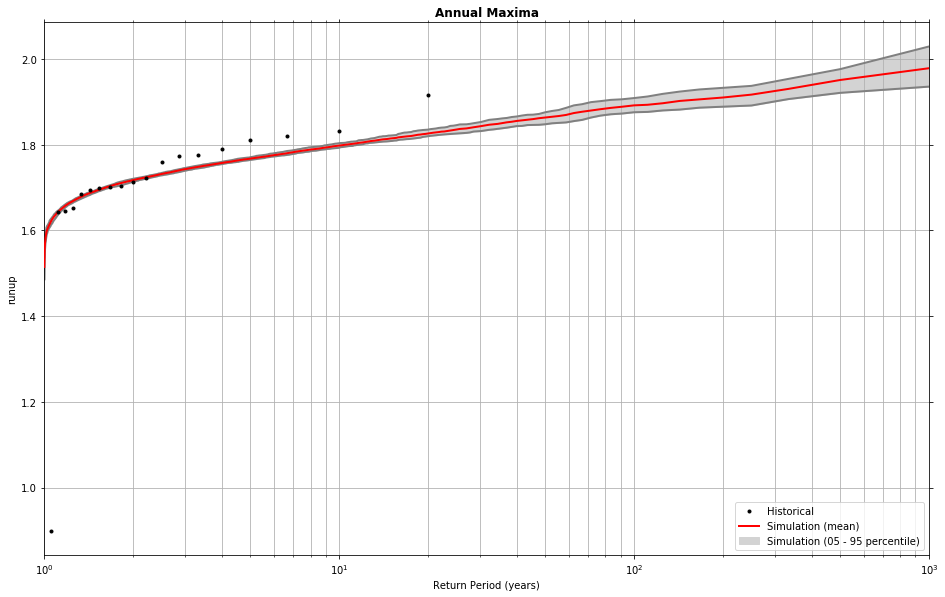

In [6]:

# compare historical and simulations runup annual maxima
hist_A = out_hist.to_xarray()['runup'].groupby('time.year').max(dim='time')
sim_A = xr.concat([x.to_xarray()['runup'].groupby('time.year').max(dim='time') for x in l_sims], 'n_sim')

# Return Period historical vs. simulations
Plot_ReturnPeriodValidation(hist_A, sim_A);
    